In [13]:
%load_ext autoreload
%autoreload 2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import cartopy.crs as ccrs
from scipy.stats import binned_statistic_2d
import cartopy.feature as cfeature
import matplotlib.patches as mpatches
from src.pf_stats import *
from src.plotting import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [39]:
# Load data, only keep complete PFs
pf_stats = load_global_pf_stats()
pf_stats = pf_stats[pf_stats['is_complete']]

# Sort data into different ranges depending on MaxPr
stats_dict = {}
bounds = [(0,30), (30, 60), (60,np.inf)]
for (lb, ub) in bounds:
    range_id = (
        (lb<pf_stats['max_precip'])
        & (pf_stats['max_precip']<ub)
    )
    stats_dict[(lb, ub)] = pf_stats[range_id]

# Choose grid for maps
# Plot data on 2x2 grid
lat_bins = np.arange(-60, 60, 2)
lon_bins = np.arange(-180, 180, 2)
lon_mesh, lat_mesh = np.meshgrid(lon_bins, lat_bins)

# Make function to generate maps
def _plot(ax, data, cmap, norm, title):
    cmap_to_plot = make_discrete_cmap(cmap, 20)
    c = ax.pcolormesh(
        lon_mesh, 
        lat_mesh, 
        data, 
        cmap=cmap_to_plot, 
        norm=norm,
        transform=ccrs.PlateCarree()
    )
    ax.set_title(title)
    ax.coastlines()
    ax.set_extent([-180, 180, -20, 20], crs=ccrs.PlateCarree())
    cb = fig.colorbar(c, ax=ax, orientation='horizontal', pad=0.05)

    # Add box showing gSAM domain
    rect = mpatches.Rectangle(
        (130, 0),  # (lon_min, lat_min)
        40,        # width in degrees
        20,        # height in degrees
        linewidth=0.75,
        edgecolor='white',
        facecolor='none',
        transform=ccrs.PlateCarree()
    )
    ax.add_patch(rect)

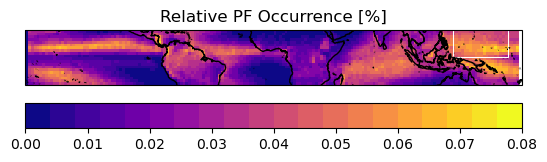

In [44]:
num_pfs = binned_statistic_2d(
        pf_stats['mean_latitude'], 
        pf_stats['mean_longitude'],
        None, 
        bins=[lat_bins, lon_bins],
        statistic='count'
).statistic
frac_pfs = 100*num_pfs/num_pfs.sum()
fig, ax = plt.subplots(subplot_kw={'projection': ccrs.PlateCarree()})
_plot(ax, frac_pfs, cmap='plasma', norm=colors.Normalize(vmin=0,vmax=0.8e-1), title=f'Relative PF Occurrence [%]')

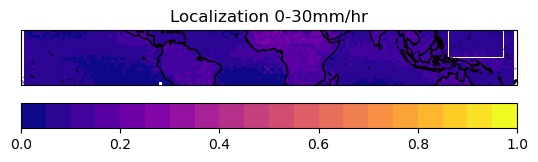

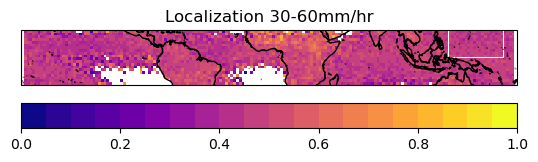

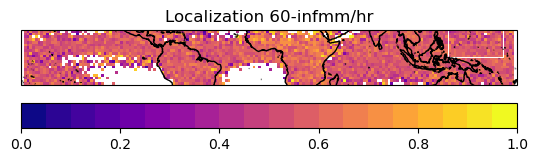

In [51]:
for (lb, ub), stats in stats_dict.items():
    loc = binned_statistic_2d(
        stats['mean_latitude'], 
        stats['mean_longitude'],
        stats['largest_10mmhr_cluster_rain']/stats['total_precip'], 
        bins=[lat_bins, lon_bins],
        statistic=np.nanmean
    ).statistic

    fig, ax = plt.subplots(subplot_kw={'projection': ccrs.PlateCarree()})
    _plot(ax, loc, cmap='plasma', norm=colors.Normalize(vmin=0,vmax=1), title=f'Localization {lb:.0f}-{ub:.0f}mm/hr')

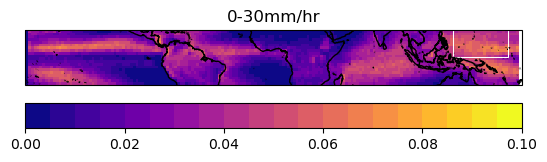

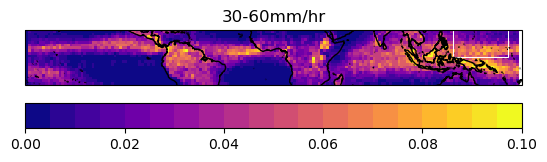

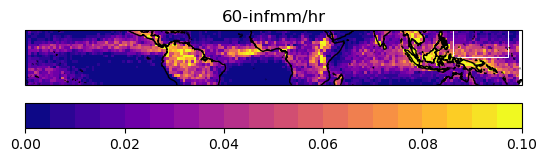

In [42]:
for (lb, ub), stats in stats_dict.items():
    num_pfs = binned_statistic_2d(
        stats['mean_latitude'], 
        stats['mean_longitude'],
        None, 
        bins=[lat_bins, lon_bins],
        statistic='count'
    ).statistic

    frac_pfs = 100*num_pfs/num_pfs.sum()
    fig, ax = plt.subplots(subplot_kw={'projection': ccrs.PlateCarree()})
    _plot(ax, frac_pfs, cmap='plasma', norm=colors.Normalize(vmin=0,vmax=1e-1), title=f'{lb:.0f}-{ub:.0f}mm/hr')
# save_figure(fig, 'Relative PF Occurence Frequency [%]')

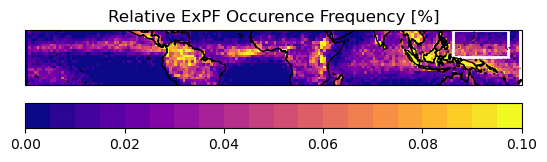

In [26]:
num_ex_pfs = binned_statistic_2d(
    extreme_pf_stats['mean_latitude'], 
    extreme_pf_stats['mean_longitude'],
    None, 
    bins=[lat_bins, lon_bins],
    statistic='count'
).statistic
fig, ax = plt.subplots(subplot_kw={'projection': ccrs.PlateCarree()})
frac_pfs = 100*num_ex_pfs/num_ex_pfs.sum()
_plot(ax, frac_pfs, cmap='plasma', norm=colors.Normalize(vmin=0,vmax=1e-1), title='Relative ExPF Occurence Frequency [%]')
# save_figure(fig, 'Relative ExPF Occurence Frequency')

/var/folders/1t/6drgwyc17q12xmq4h7m454vw0000gn/T/ipykernel_50991/3678116101.py:9: RuntimeWarning: invalid value encountered in divide
  conditional_prob = 100*num_extreme_pfs/num_pfs


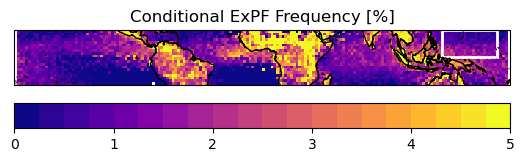

In [29]:
num_extreme_pfs = binned_statistic_2d(
    extreme_pf_stats['mean_latitude'], 
    extreme_pf_stats['mean_longitude'],
    None, 
    bins=[lat_bins, lon_bins],
    statistic='count'
).statistic
fig, ax = plt.subplots(subplot_kw={'projection': ccrs.PlateCarree()})
conditional_prob = 100*num_extreme_pfs/num_pfs
_plot(ax, conditional_prob, cmap='plasma', norm=colors.Normalize(vmin=0,vmax=5), title='Conditional ExPF Frequency [%]')
# save_figure(fig, 'Conditional ExPF Frequency')

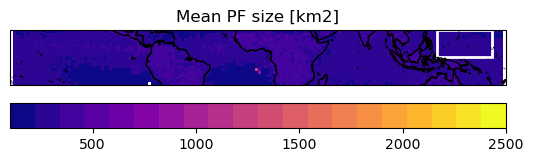

In [32]:
mean_size_in_km2 = binned_statistic_2d(
    pf_stats['mean_latitude'], 
    pf_stats['mean_longitude'],
    pf_stats['num_pixels']*25, 
    bins=[lat_bins, lon_bins],
    statistic=np.nanmean
).statistic
fig, ax = plt.subplots(subplot_kw={'projection': ccrs.PlateCarree()})
_plot(ax, mean_size_in_km2, cmap=plt.cm.plasma, norm=colors.Normalize(vmin=1e2,vmax=2.5e3), title='Mean PF size [km2]')
# save_figure(fig, 'Mean PF size')

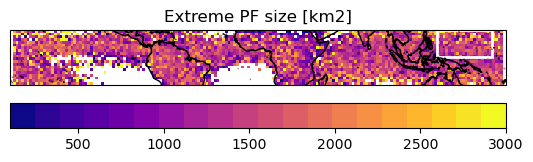

In [33]:
expf_size_in_km2 = binned_statistic_2d(
    extreme_pf_stats['mean_latitude'], 
    extreme_pf_stats['mean_longitude'],
    extreme_pf_stats['num_pixels']*25, 
    bins=[lat_bins, lon_bins],
    statistic=np.nanmean
).statistic
fig, ax = plt.subplots(subplot_kw={'projection': ccrs.PlateCarree()})
_plot(ax, expf_size_in_km2, cmap=plt.cm.plasma, norm=colors.Normalize(vmin=1e2,vmax=3e3), title='Extreme PF size [km2]')
# save_figure(fig, 'Extreme PF size')

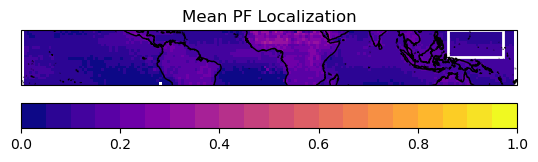

In [34]:
mean_loc = binned_statistic_2d(
    pf_stats['mean_latitude'], 
    pf_stats['mean_longitude'],
    pf_stats['largest_10mmhr_cluster_rain']/pf_stats['total_precip'], 
    bins=[lat_bins, lon_bins],
    statistic=np.nanmean
).statistic
fig, ax = plt.subplots(subplot_kw={'projection': ccrs.PlateCarree()})
_plot(ax, mean_loc, cmap=plt.cm.plasma, norm=colors.Normalize(vmin=0,vmax=1), title='Mean PF Localization')
save_figure(fig, 'Mean PF loc')

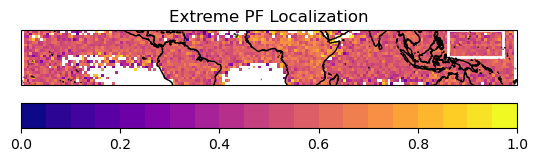

In [35]:
extreme_loc = binned_statistic_2d(
    extreme_pf_stats['mean_latitude'], 
    extreme_pf_stats['mean_longitude'],
    extreme_pf_stats['largest_10mmhr_cluster_rain']/extreme_pf_stats['total_precip'], 
    bins=[lat_bins, lon_bins],
    statistic=np.nanmean
).statistic
fig, ax = plt.subplots(subplot_kw={'projection': ccrs.PlateCarree()})
_plot(ax, extreme_loc, cmap=plt.cm.plasma, norm=colors.Normalize(vmin=0,vmax=1), title='Extreme PF Localization')
save_figure(fig, 'Extreme PF loc')